In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
# wrapper so that model predicts using dask
from dask_ml.wrappers import ParallelPostFit  

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe 

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set
whole_set = False

root = os.path.join(os.getcwd(), 'data_sampling_workflow')
train_name = 'ptpoly2_train_2020.csv'
test_name = 'ptpoly2_test_2020.csv'

first_feature = 'r'
last_feature = 'day_in_year'
label_name = 'iceplant'

filter_year = True
year = 2020
# drops this feature

save_model = True
model_name = 'ptpoly2_model_2020_rfc'

calculate_feature_importance = True

In [3]:
# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name)).loc[:, first_feature:last_feature]
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name)).loc[:, first_feature:last_feature]
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 

# ------------------------------
if filter_year:
    
    X_train = X_train.loc[X_train.year == year]
    X_train = X_train.drop(['year'], axis =1)
    y_train = y_train.iloc[X_train.index]

    
    X_test = X_test.loc[X_test.year == year]
    X_test = X_test.drop(['year'], axis =1)
    y_test = y_test.iloc[X_test.index]
    
# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)


X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [4]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [5]:
t0 = time.time()
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
print(time.time() - t0)

if save_model:
    dump(rfc, model_name +'.joblib')

0.21814465522766113


In [11]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 179     false positives: 9
false negatives: 22     true positives: 64

sensitivity (TP/P): 74.42 %
specificity (TN/N): 95.21 %
G-mean:  0.84

precision (TP/(TP+FP)): 87.67 %

MCC:  0.7309263781996601

F1-measure:  0.80503
F0.5-measure (min false positives):  0.84656
F2-measure (min false negatives)  :  0.76739

accuracy: 88.69 %


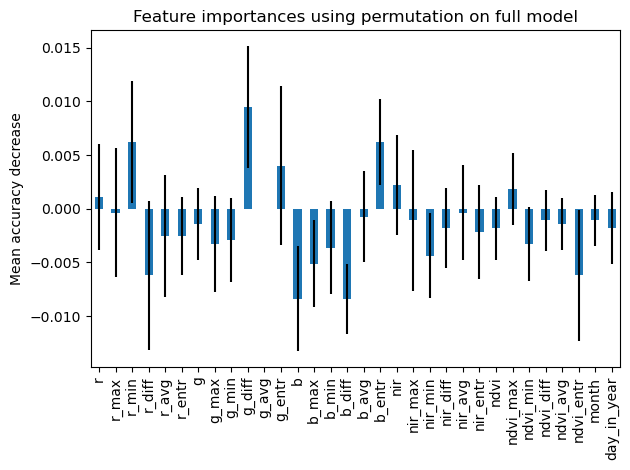

In [7]:
result = permutation_importance(
    rfc, 
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Note:
There are some points in the training and test set that have negative values for min_lidar. 
This is most likely points near the coast where the 3x3 window around the point includes no-data pixels in the canopy height raster.
No-data in the canopy height raster is represented by -999.
However, as a percentage of the points in the total training and test set, these are very few points:

0	275	(non-iceplant with negative min_lidar)
1	559	(iceplant with negative min_lidar)